<a href="https://colab.research.google.com/github/ArtisVansovics/loan_data_analysis/blob/main/loan_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Application Risk Assesment

## Introduction
A data set of 10 000 historical loan application samples is provided. By using the data set a classification model is built in order to predict, if a new client will default or pay back the loan.

The target variable for the model is *First Payment Delay 30 days* (**fdp30**). Value of 1 means that the client defaulted, by not being able to pay back the loan in less than 30 days from the designated loan repayment period. O means that the client was able to repay the loan in time.

## Loading the Data

In [274]:
import numpy as np
import pandas as pd
import os

# Import for value encoding
from sklearn.preprocessing import LabelEncoder

# Import for splitting the data set
from sklearn.model_selection import train_test_split

# Import for standardizing the data values
from sklearn.preprocessing import StandardScaler  

# Imports to set up plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Loading graphics in retina format to make them more sharp and legible
%config InlineBackend.figure_format = 'retina'

# Precision of printed numerical values of the Pandas data frame
pd.set_option("display.precision", 2)

# Imports for Google Sheet access
from google.colab import auth
import gspread
from google.auth import default

# Loading initial data set
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
worksheet = gc.open('all_data_set').sheet1

# Saving initial data set as a Pandas DataFrame
df = pd.DataFrame(worksheet.get_all_records())
# Copying data set for reference
df_copy = df.copy()

## Checking the Data

In [275]:
df.head()

,r_application_id,app_date,amount,original_amount,term,original_term,commission_charged,gender,dob,email,...,provider_5_device_os,provider_5_device_screen,provider_5_device_type,provider_5_rule_zero,provider_5_rule_one,provider_5_rule_two,provider_5_rule_three,credit_limit,new_income,new_liabilities
0,233991,2018-03-26 13:11:58,1000.0,1000.0,30,30,250,0,1988-10-25,test@wp.pl,...,WINDOWS NT 6.1,1024X1280,WINDOWS,,,,,1000.0,2200.0,200.0
1,234008,2018-03-26 13:26:38,1500.0,2500.0,30,30,375,0,1975-11-22,test@wp.pl,...,WINDOWS NT 10.0,768X1366,WINDOWS,,,,,1500.0,5800.0,600.0
2,234010,2018-03-26 13:27:51,300.0,1000.0,30,30,75,1,1995-04-04,test@gmail.com,...,WINDOWS NT 6.1,1080X1920,WINDOWS,,,,,300.0,2350.0,300.0
3,234155,2018-03-26 15:47:22,1500.0,2500.0,30,30,375,1,1983-12-12,test@vp.pl,...,ANDROID 6.0.1,640X360,ANDROID,,,,,1500.0,2600.0,1000.0
4,234006,2018-03-26 13:24:59,400.0,400.0,30,30,100,1,1992-03-10,test@onet.pl,...,ANDROID 7.0,640X360,ANDROID,,,,,1000.0,2100.0,300.0


In [276]:
df.isnull().sum().max()

0

In [277]:
len(df[df.duplicated()])

0

In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 84 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   r_application_id                          10000 non-null  int64  
 1   app_date                                  10000 non-null  object 
 2   amount                                    10000 non-null  float64
 3   original_amount                           10000 non-null  float64
 4   term                                      10000 non-null  int64  
 5   original_term                             10000 non-null  int64  
 6   commission_charged                        10000 non-null  int64  
 7   gender                                    10000 non-null  int64  
 8   dob                                       10000 non-null  object 
 9   email                                     10000 non-null  object 
 10  employment_status                  

There are 10 000 data entries and 84 data points. There are also no null values or duplicates in the data set. Most columns have the object data type, which signifies that they hold mixed data types. For data modelling they should be transformed into numeric values.

## Exploring the Data

In [279]:
# Plot for number of applications for a feature and fraction of applications that defaulted 
def fract_plot(feature,label_rotation=False):

    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of applications': temp.values})

    # Calculate the fraction of fpd30 = 1 per category value
    cat_fract = df[[feature, 'fpd30']].groupby([feature], as_index=False).mean()
    # cat_fract.sort_values(by='fpd30', ascending=False, inplace=True)
    
    sns.set_style('whitegrid')
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))

    s = sns.barplot(ax=ax1, x=feature, y='Number of applications', data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(), rotation=90)
    
    s = sns.barplot(ax=ax2, x=feature, y='fpd30', order=cat_fract[feature], data=cat_fract)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.ylabel('Fraction of applications with fpd30 = 1')
    plt.tick_params(axis='both', which='major')

    plt.show();

In [280]:
# Plot distribution of one feature
def distribution_plot(feature,title,color):

    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % title)
    sns.histplot(df[feature].dropna(), color=color, kde=True, bins=100)

    plt.show()   

In [281]:
# Plot distribution of multiple features, with fpd30 = 1/0 on the same graph
# A kernel density estimate (KDE) plot displays the distribution of data in a data set, similarly to a histogram
def distribution_plot_several(var,titles,nrow=2):
    
    i = 0
    t1 = df.loc[df['fpd30'] != 0]
    t0 = df.loc[df['fpd30'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(16,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t0[feature], bw_adjust=0.5, label='fpd30 = 0')
        sns.kdeplot(t1[feature], bw_adjust=0.5, label='fpd30 = 1')
        plt.title("Distribution of %s" % titles[i-1], fontsize=14)
        plt.ylabel('Density', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.legend()

    plt.show();

### Distribution of Defaulted Clients

In [282]:
s1 = df['fpd30'].value_counts()
s2 = df['fpd30'].value_counts(normalize=True)
df30 = pd.DataFrame(s1)
df30.columns = ['count']
df30['fraction'] = s2
df30 = df30.style.set_caption('fdp30 Values')

df30

,count,fraction
0,8206,0.82
1,1794,0.18


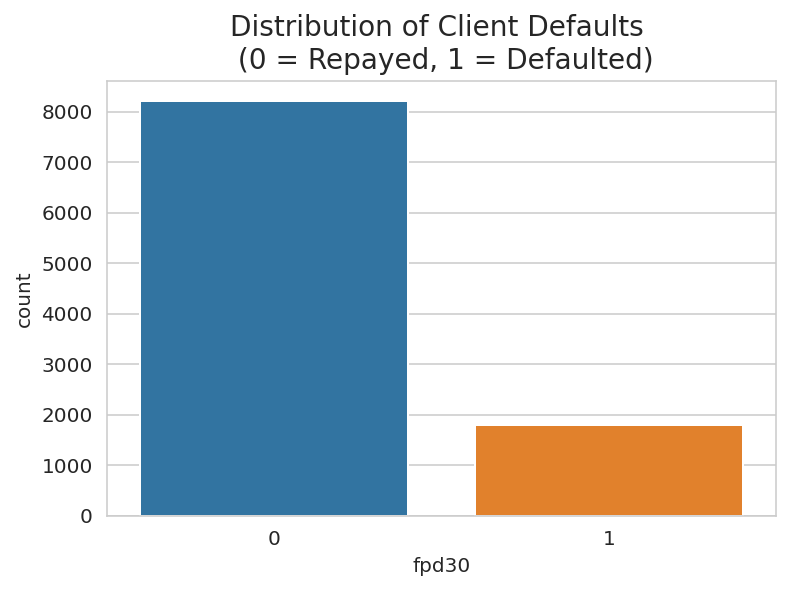

In [283]:
sns.countplot(x='fpd30', data=df)
plt.title('Distribution of Client Defaults \n (0 = Repayed, 1 = Defaulted)', fontsize=14)
sns.set_style('whitegrid')

plt.show()

In total 1794 clients or 18% defaulted (fpd30 = 1), while 82% were able to pay back their loans. This also means that the data set is unbalanced in regards of the target variable fpd30 as only a fraction of applications resulted in a default.

### Loan Amounts

<Figure size 432x288 with 0 Axes>

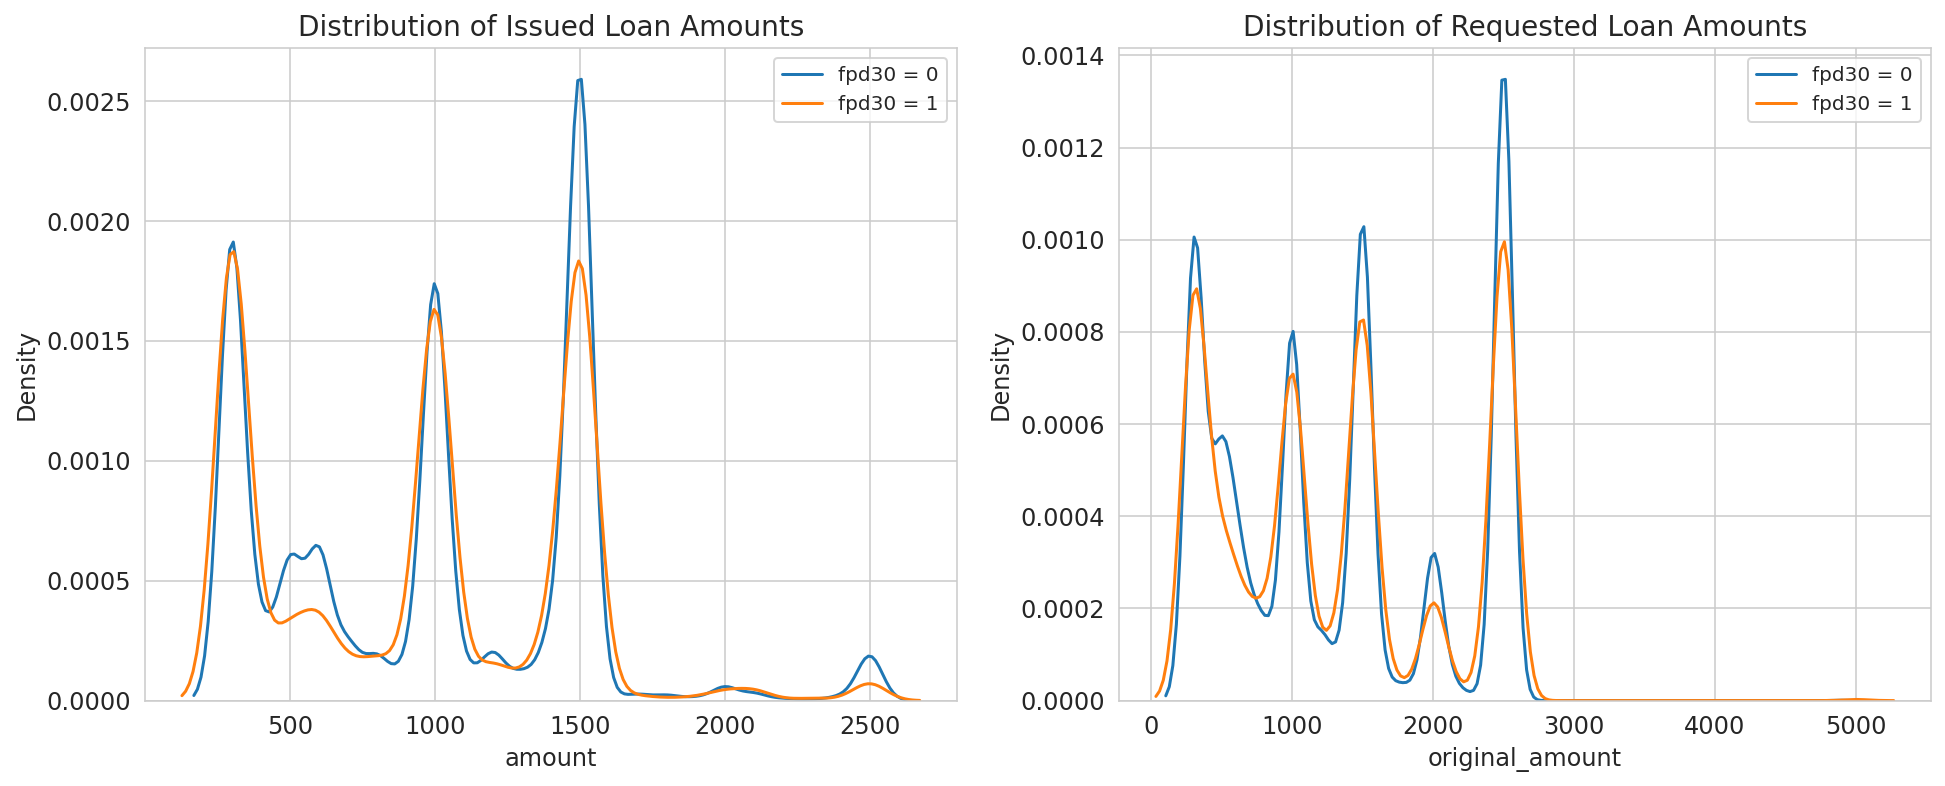

In [284]:
var = ['amount', 'original_amount']
titles = ['Issued Loan Amounts', 'Requested Loan Amounts']

distribution_plot_several(var,titles,nrow=1)

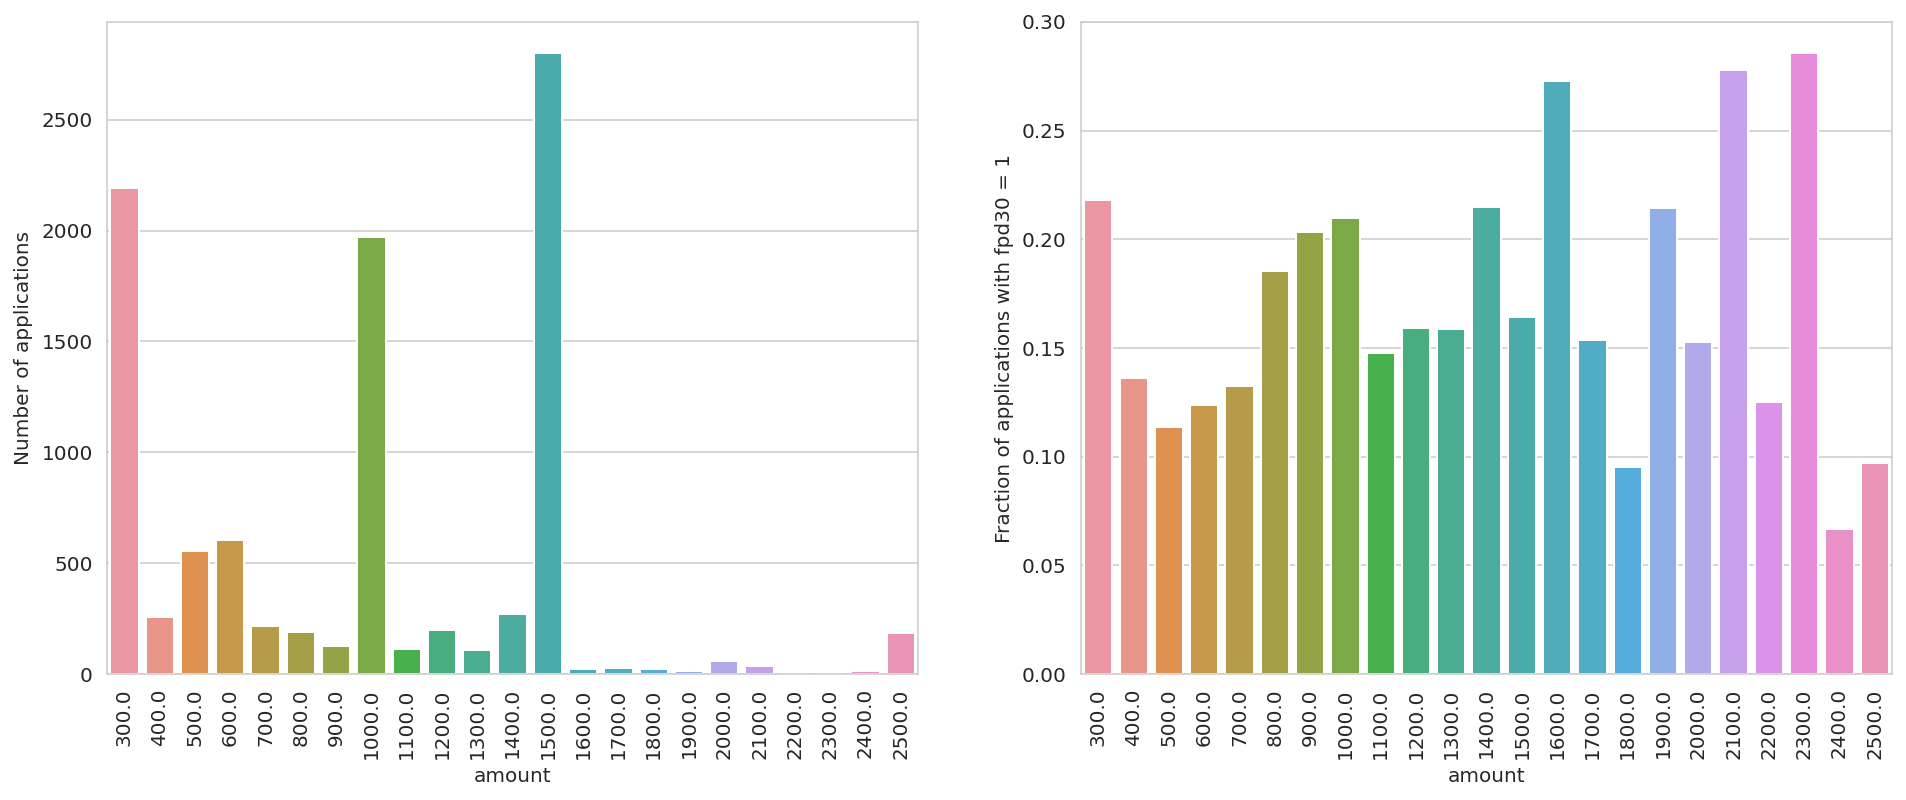

In [285]:
fract_plot('amount',True)

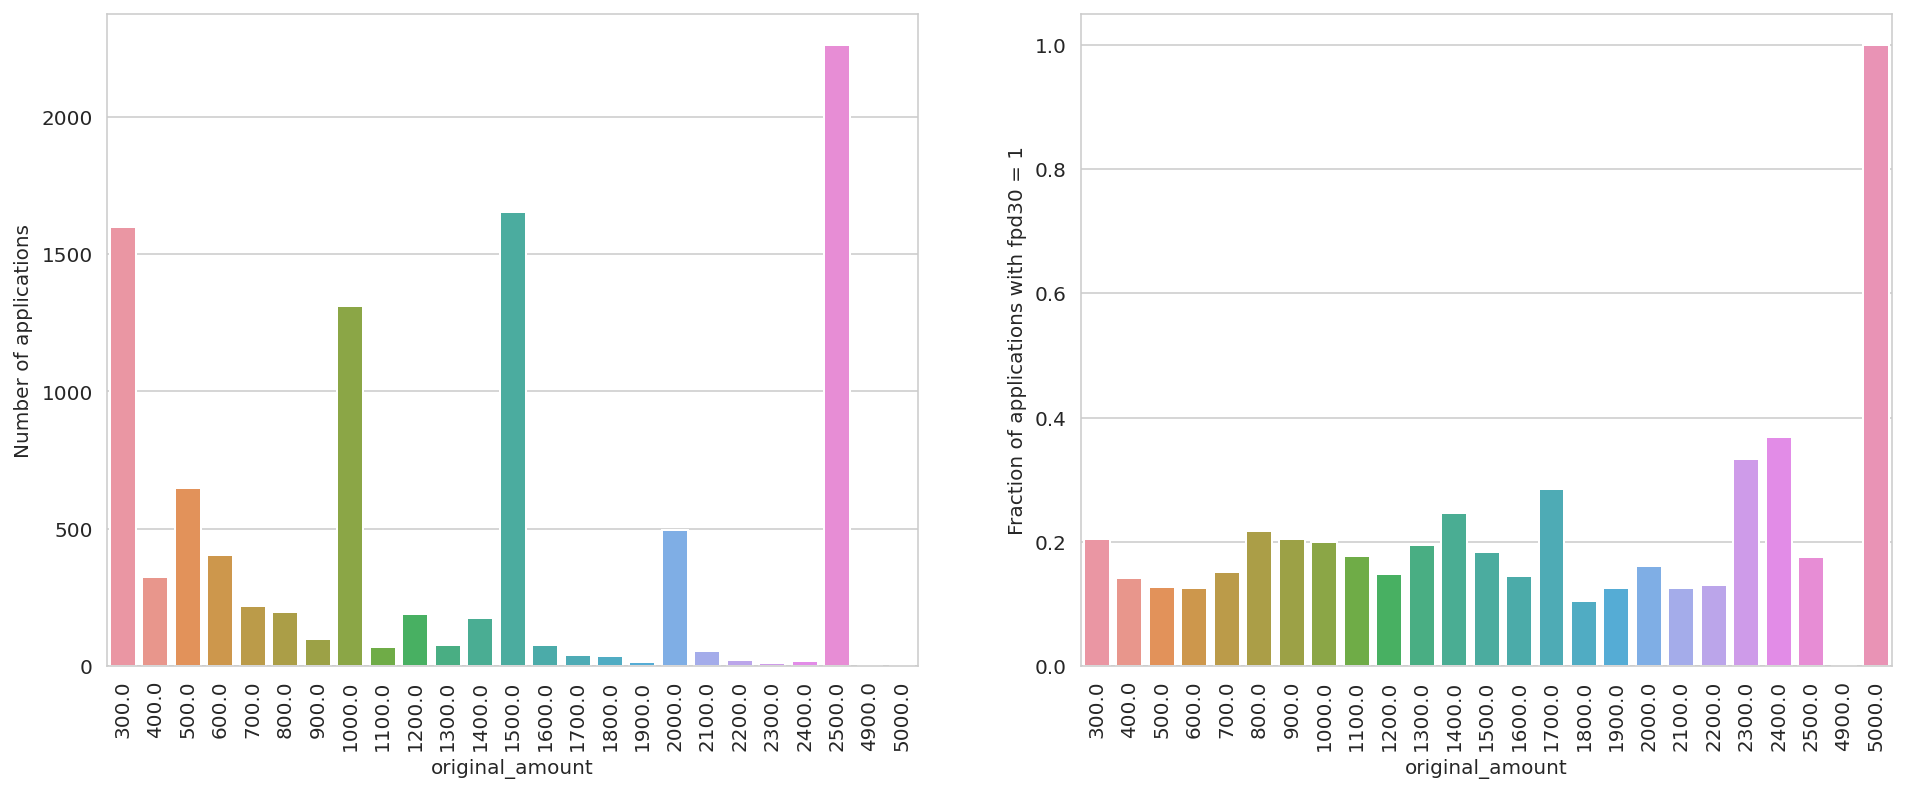

In [286]:
fract_plot('original_amount',True)

Distribution of loan amounts shows that most of the loans given are under 1600. In general, most people either received the smaller, 300 loan amount, a medium 1000 loan, or the 1500 loan, which is the most commmonly distributed loan amount. On the other hand, the most popular originally requested loan amount of 2500 has been approved to only a relatively small amount of clients as it also apears to be the largest approved amount. In addition, 100% of clients requesting initial loan of 5000 defaulted.

### Loan Term

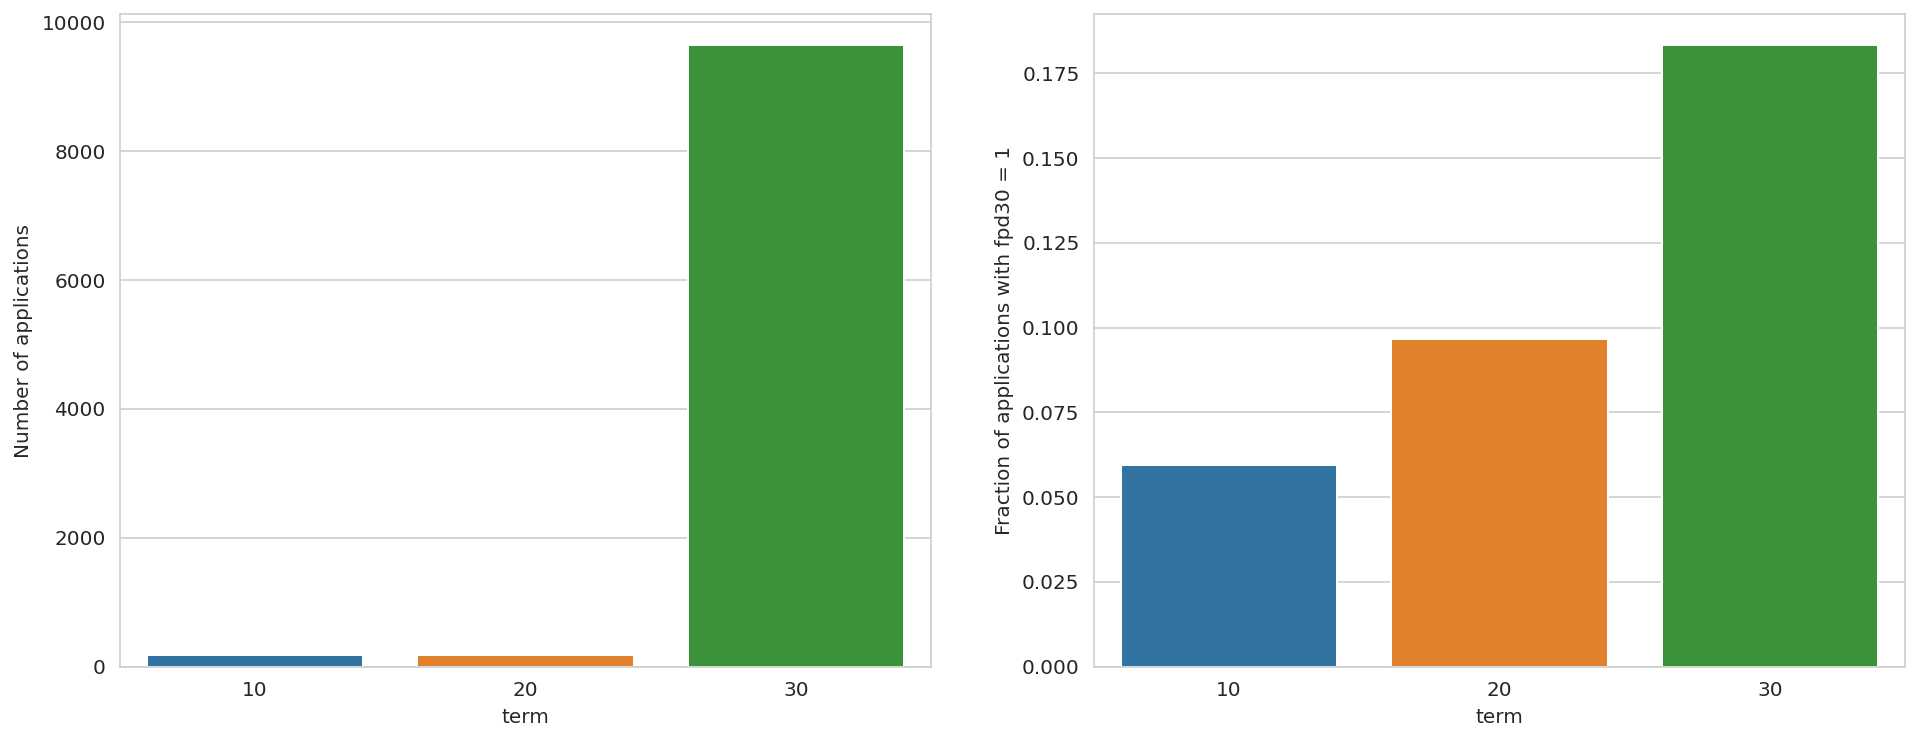

In [287]:
fract_plot('term')

Almost all loans were given with a 30 day term and 30 day loans also have the largest amount of defaults.

### Client Employment

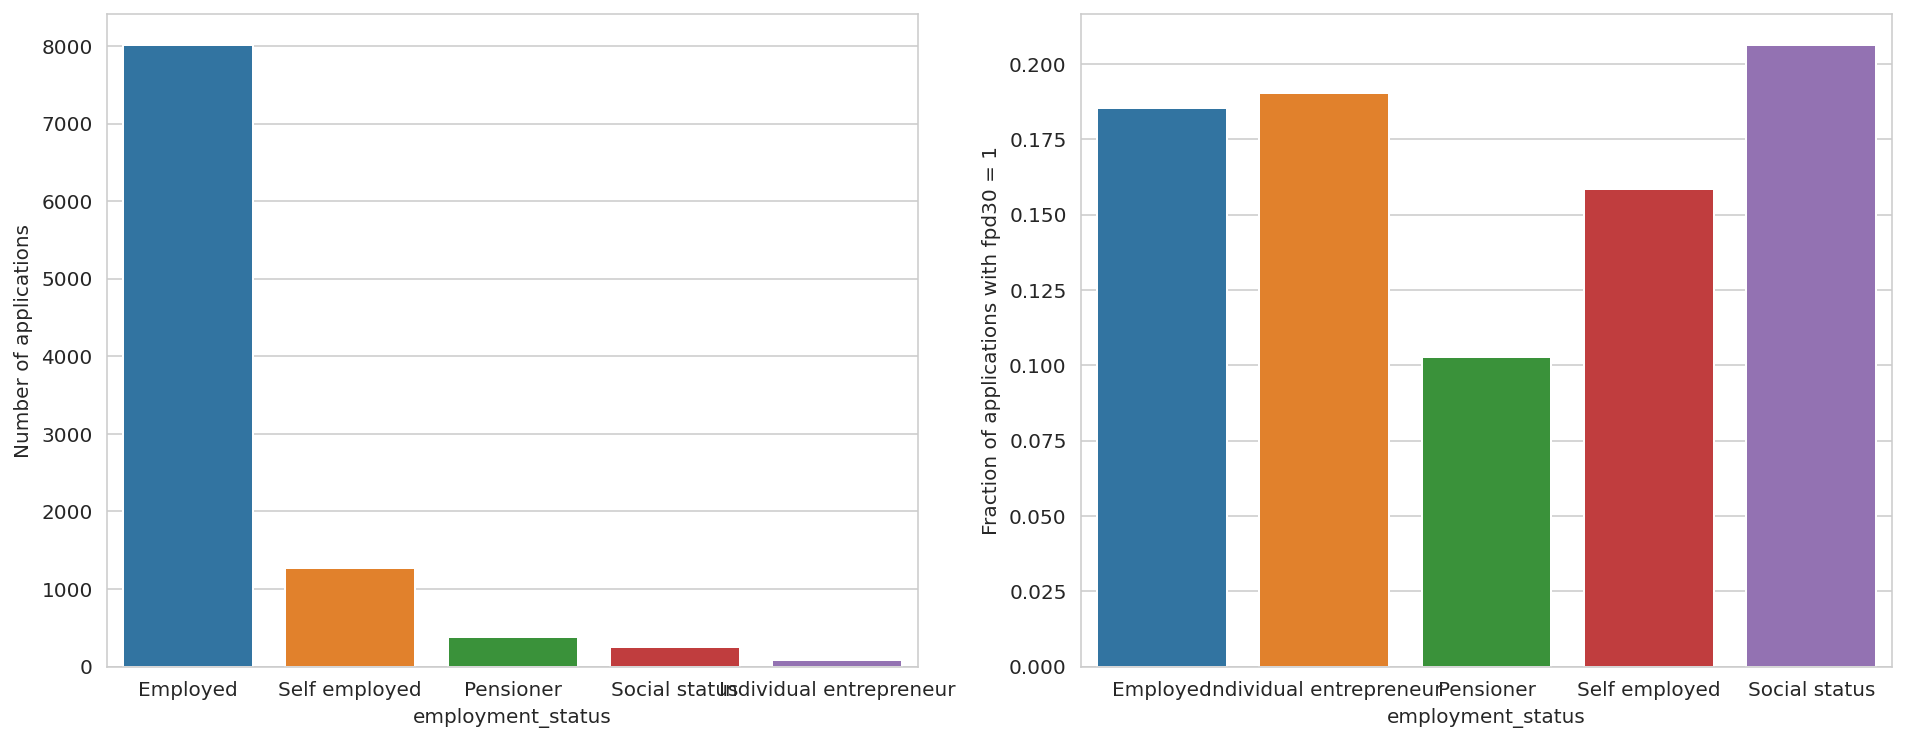

,Label
0,Employed
1,Individual entrepreneur
2,Pensioner
3,Self employed
4,Social status


In [288]:
fract_plot('employment_status',False)
s = {'Label': le_emp.inverse_transform([0, 1, 2, 3, 4])} 
temp = pd.DataFrame(data=s)
temp

The majority of clients were employed, with the second largest client group being self employed people. Over 20% of clients with a social status did not pay back the loan in time, while individual enterpreneurs and employed clients defaulted at about the average rate of the data set (18%). The group least likely to default were pensioners.

## Data Pre-Processing

### Cleaning the Data

Machine learning algorithms need all values to numerical in order to function properly. Therefore, categorical features need to be encoded as numbers before modelling can be done. Furthermore, mixed (object) data types also need to be converted to numbers.

In [289]:
# Removing unnecessary data points
remove = ['r_application_id', 'app_date', 'email', 'provider_1_first_seen', 'provider_1_last_loan_created', 'provider_1_late_debt_count', 'provider_1_late_debt_sum', 'provider_2_total_debt', 'provider_2_negative_count', 'provider_3_total_arrears', 'provider_3_debitors_count', 'provider_3_creditors_count', 'provider_3_last_paid_debt_date', 'provider_4_neg_loan_overdue_sum', 'provider_5_device_browser_charset', 'provider_5_device_browser_lang', 'provider_5_device_browser_type', 'provider_5_device_cookie_enabled', 'provider_5_device_firstseen', 'provider_5_device_os', 'provider_5_device_screen', 'provider_5_rule_zero', 'provider_5_rule_one', 'provider_5_rule_two', 'provider_5_rule_three']
df = df.drop(columns=remove)

# Converting string date values into integers
df['dob'] = df['dob'].str.replace('-','').astype(int)

# Replacing boolean True/False values with 1/0
booleans = ['accept_marketing', 'ignore_communication', 'identified_by_provider_6']
df[booleans] = df[booleans].replace({'True': 1, 'False': 0})

# Replacing object 1.0/0.0/"" values with 1/0
df['provider_5_device_new'] = df['provider_5_device_new'].apply(pd.to_numeric, errors='coerce')
df['provider_5_device_new'] = df['provider_5_device_new'].fillna(df['provider_5_device_new'].mode()[0])
df['provider_5_device_new'] = df['provider_5_device_new'].astype(int)

# Converting object values to numeric values. Coerce sets invalid values to NaN
numbers = ['provider_1_current_debt_total', 'new_liabilities', 'provider_5_device_bb_age']
df[numbers] = df[numbers].apply(pd.to_numeric, errors='coerce')
df.loc[:, 'provider_1_current_debt_total':'provider_4_pos_paid_sum'] = df.loc[:, 'provider_1_current_debt_total':'provider_4_pos_paid_sum'].apply(pd.to_numeric, errors='coerce')

# Encoding categorical values to numeric labels
le_emp = LabelEncoder()
le_dev = LabelEncoder()
df['employment_status'] = le_emp.fit_transform(df['employment_status'])

# Replacing empty device type value with unknown
df['provider_5_device_type']= df['provider_5_device_type'].replace('', 'unknown')
df['provider_5_device_type'] = le_dev.fit_transform(df['provider_5_device_type'])

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 59 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   amount                                    10000 non-null  float64
 1   original_amount                           10000 non-null  float64
 2   term                                      10000 non-null  int64  
 3   original_term                             10000 non-null  int64  
 4   commission_charged                        10000 non-null  int64  
 5   gender                                    10000 non-null  int64  
 6   dob                                       10000 non-null  int64  
 7   employment_status                         10000 non-null  int64  
 8   accept_marketing                          10000 non-null  int64  
 9   ignore_communication                      10000 non-null  int64  
 10  rejected_applications              

In [291]:
df.isnull().sum().max()

6427

Unnecessary or empty data points are removed, leaving 59 columns. As erroneous values were converted into NaN, they should be replaced with the mean value of the specific data point. Also, average actual current debt sum from Credit Bureau 1 (provider_1_avg_current_actual_debt) should be removed, as it mostly consists of NaN values, and could skew the data.

In [292]:
# Removing average actual current debt sum
df = df.drop(columns='provider_1_avg_current_actual_debt')
# Replacing NaN values with column mean
df = df.fillna(df.mean())

df.isnull().sum().max()

0

In [293]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
amount,10000.0,9.74e+02,529.48,3.00e+02,5.00e+02,1.00e+03,1.50e+03,2.50e+03
original_amount,10000.0,1.32e+03,802.98,3.00e+02,5.00e+02,1.20e+03,2.00e+03,5.00e+03
term,10000.0,2.95e+01,2.98,1.00e+01,3.00e+01,3.00e+01,3.00e+01,3.00e+01
original_term,10000.0,2.95e+01,2.97,1.00e+01,3.00e+01,3.00e+01,3.00e+01,3.00e+01
commission_charged,10000.0,2.41e+02,133.89,3.60e+01,1.00e+02,2.50e+02,3.75e+02,6.50e+02
gender,10000.0,5.51e-01,0.50,0.00e+00,0.00e+00,1.00e+00,1.00e+00,1.00e+00
dob,10000.0,1.98e+07,112641.50,1.95e+07,1.98e+07,1.99e+07,1.99e+07,2.00e+07
employment_status,10000.0,5.68e-01,1.18,0.00e+00,0.00e+00,0.00e+00,0.00e+00,4.00e+00
accept_marketing,10000.0,9.21e-01,0.27,0.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
ignore_communication,10000.0,2.16e-02,0.15,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00


In [294]:
df.head()

,amount,original_amount,term,original_term,commission_charged,gender,dob,employment_status,accept_marketing,ignore_communication,...,provider_4_pos_loan_count,provider_4_pos_paid_sum,fpd30,identified_by_provider_6,provider_5_device_bb_age,provider_5_device_new,provider_5_device_type,credit_limit,new_income,new_liabilities
0,1000.0,1000.0,30,30,250,0,19881025,0,1,0,...,25.0,34502.0,0,0,48.0,1,8,1000.0,2200.0,200.0
1,1500.0,2500.0,30,30,375,0,19751122,3,1,0,...,1.0,755.0,0,0,2575.0,0,8,1500.0,5800.0,600.0
2,300.0,1000.0,30,30,75,1,19950404,0,1,0,...,10.0,3329.0,0,0,1282.0,1,8,300.0,2350.0,300.0
3,1500.0,2500.0,30,30,375,1,19831212,0,1,0,...,7.0,3642.0,1,1,1352.0,1,0,1500.0,2600.0,1000.0
4,400.0,400.0,30,30,100,1,19920310,0,1,0,...,4.0,1450.0,0,0,10366.0,1,0,1000.0,2100.0,300.0


### Splitting the Data Set

For the model independent variables (the features) have to be separated from the dependent variables, which are the output. In this case the dependent variable is First Payment Delay 30 days.

In [295]:
# Independent variables
x = df.loc[:, df.columns != 'fpd30'].values
# Dependent variable
y = df.loc[:,'fpd30'].values 

In order to create a Machine Learning model the data set also needs to be split into two parts - training set and test set. Training set is used to train the model, while test set is used to test the accuracy of the model. For this model the data set will be divided in sub-sets in a 80:20 ratio.

In [296]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, random_state=0)

### Scaling Features

Feature scaling is used to standardize variables of the data set within a specific range in order to make their comparison easier as the varied size of feature values could produce erroneous results. For this project standardization method will be used for scaling.

In [300]:
st_x= StandardScaler()

x_train= st_x.fit_transform(x_train) 

x_test= st_x.transform(x_test) 

## Test

In [ ]:
plt.figure(figsize = (12,6))
plt.title('Client Employment Status')
sns.set_color_codes("pastel")
s = sns.countplot(x='employment_status', hue="fpd30", data=df)

plt.xticks(rotation=30)

plt.show()

In [5]:
columns = ['amount', 'original_amount']

df.groupby(df['fpd30'], as_index=False)[columns].count()

,fpd30,amount,original_amount
0,0,8206,8206
1,1,1794,1794


In [47]:
columns = ['amount', 'original_amount']

df.pivot_table(
    columns,
    ["fpd30"],
    aggfunc="mean",
)



,amount,original_amount
fpd30,,
0,981.85,1320.4
1,940.86,1317.5


In [ ]:
df[df["fpd30"] == 1].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


r_application_id                           233617.36
amount                                        940.86
original_amount                              1317.50
term                                           29.78
original_term                                  29.79
commission_charged                            233.65
gender                                          0.62
rejected_applications                           0.65
provider_1_count_providers                      4.05
provider_1_confirmed_accounts                   3.34
provider_1_nonconfirmed_accounts                0.71
provider_2_positive_supplier_count              1.96
provider_2_negative_count                       0.00
provider_2_positive_count                       9.02
provider_2_total_debt                           0.00
provider_3_debitors_count                       0.00
provider_3_creditors_count                      0.00
provider_3_total_arrears                        0.00
provider_3_providers_count                    

In [ ]:
df[df["fpd30"] == 0].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


r_application_id         234679.27
amount                      981.85
original_amount            1320.40
term                         29.38
original_term                29.38
commission_charged          243.14
gender                        0.54
rejected_applications         0.36
fpd30                         0.00
credit_limit               1191.13
new_income                 2563.49
dtype: float64

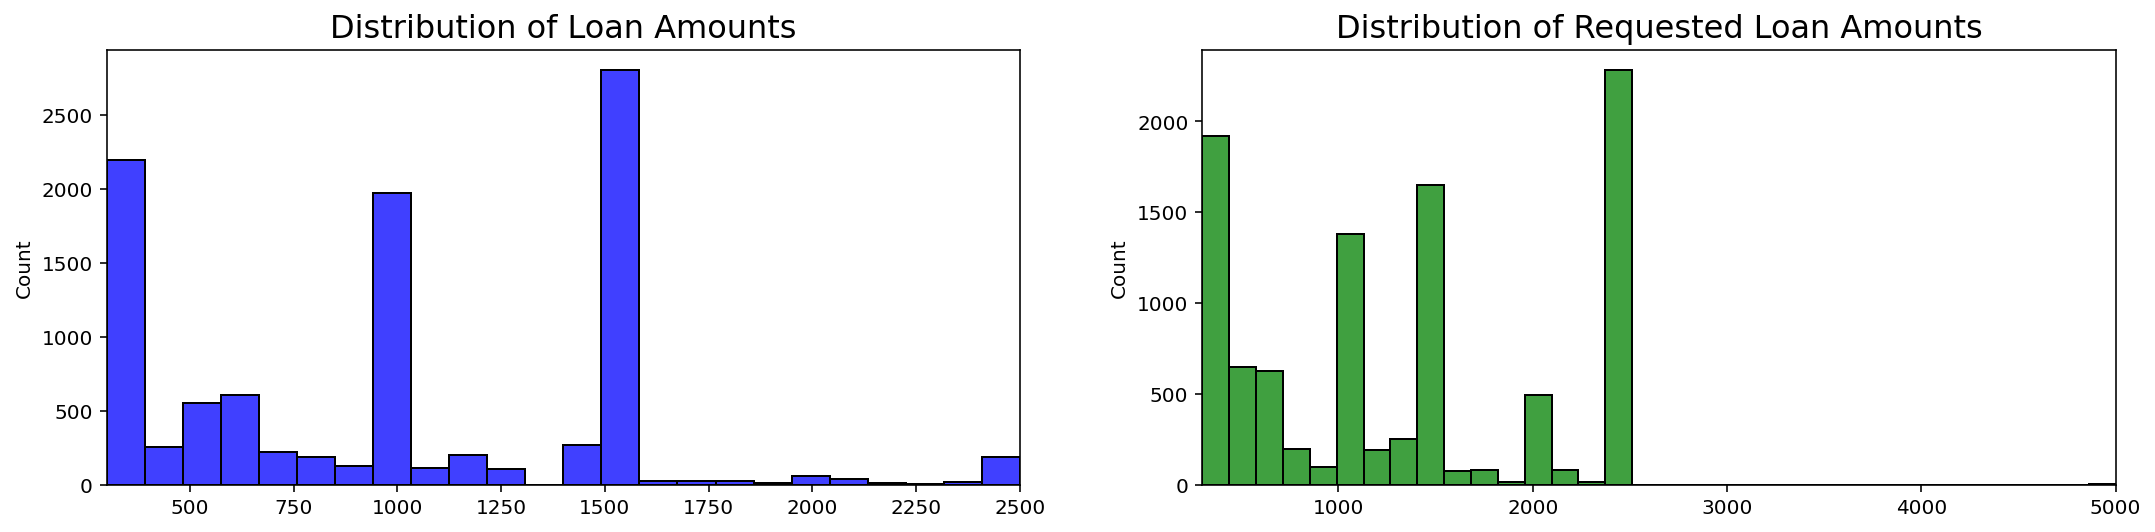

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_value = df['amount'].values
orig_amount_value = df['original_amount'].values

sns.histplot(amount_value, ax=ax[0], color='b')
ax[0].set_title('Distribution of Loan Amounts', fontsize=16)
ax[0].set_xlim([min(amount_value), max(amount_value)])

sns.histplot(orig_amount_value, ax=ax[1], color='g')
ax[1].set_title('Distribution of Requested Loan Amounts', fontsize=16)
ax[1].set_xlim([min(orig_amount_value), max(orig_amount_value)])

plt.show()

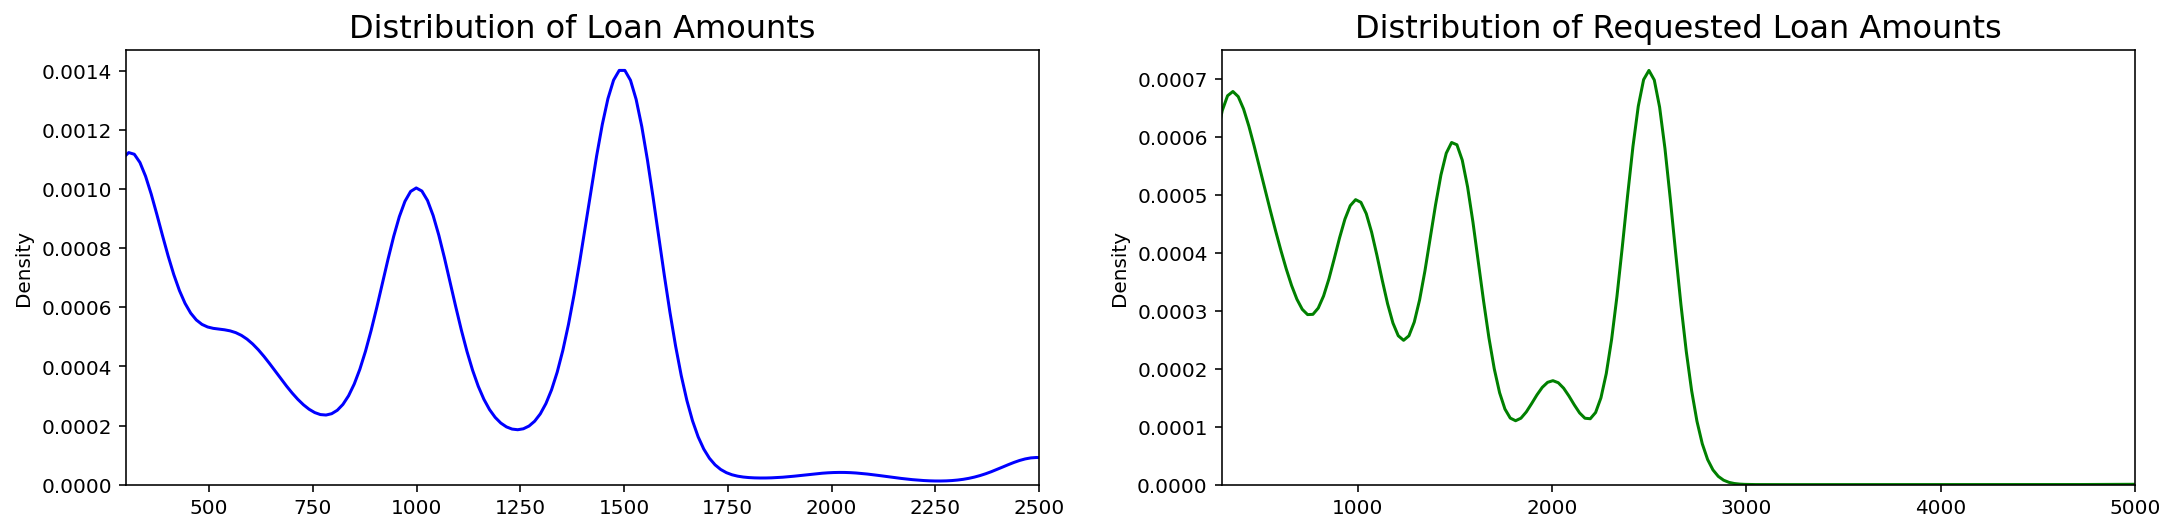

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_value = df['amount'].values
orig_amount_value = df['original_amount'].values

sns.kdeplot(amount_value, ax=ax[0], color='b')
ax[0].set_title('Distribution of Loan Amounts', fontsize=16)
ax[0].set_xlim([min(amount_value), max(amount_value)])

sns.kdeplot(orig_amount_value, ax=ax[1], color='g')
ax[1].set_title('Distribution of Requested Loan Amounts', fontsize=16)
ax[1].set_xlim([min(orig_amount_value), max(orig_amount_value)])

plt.show()

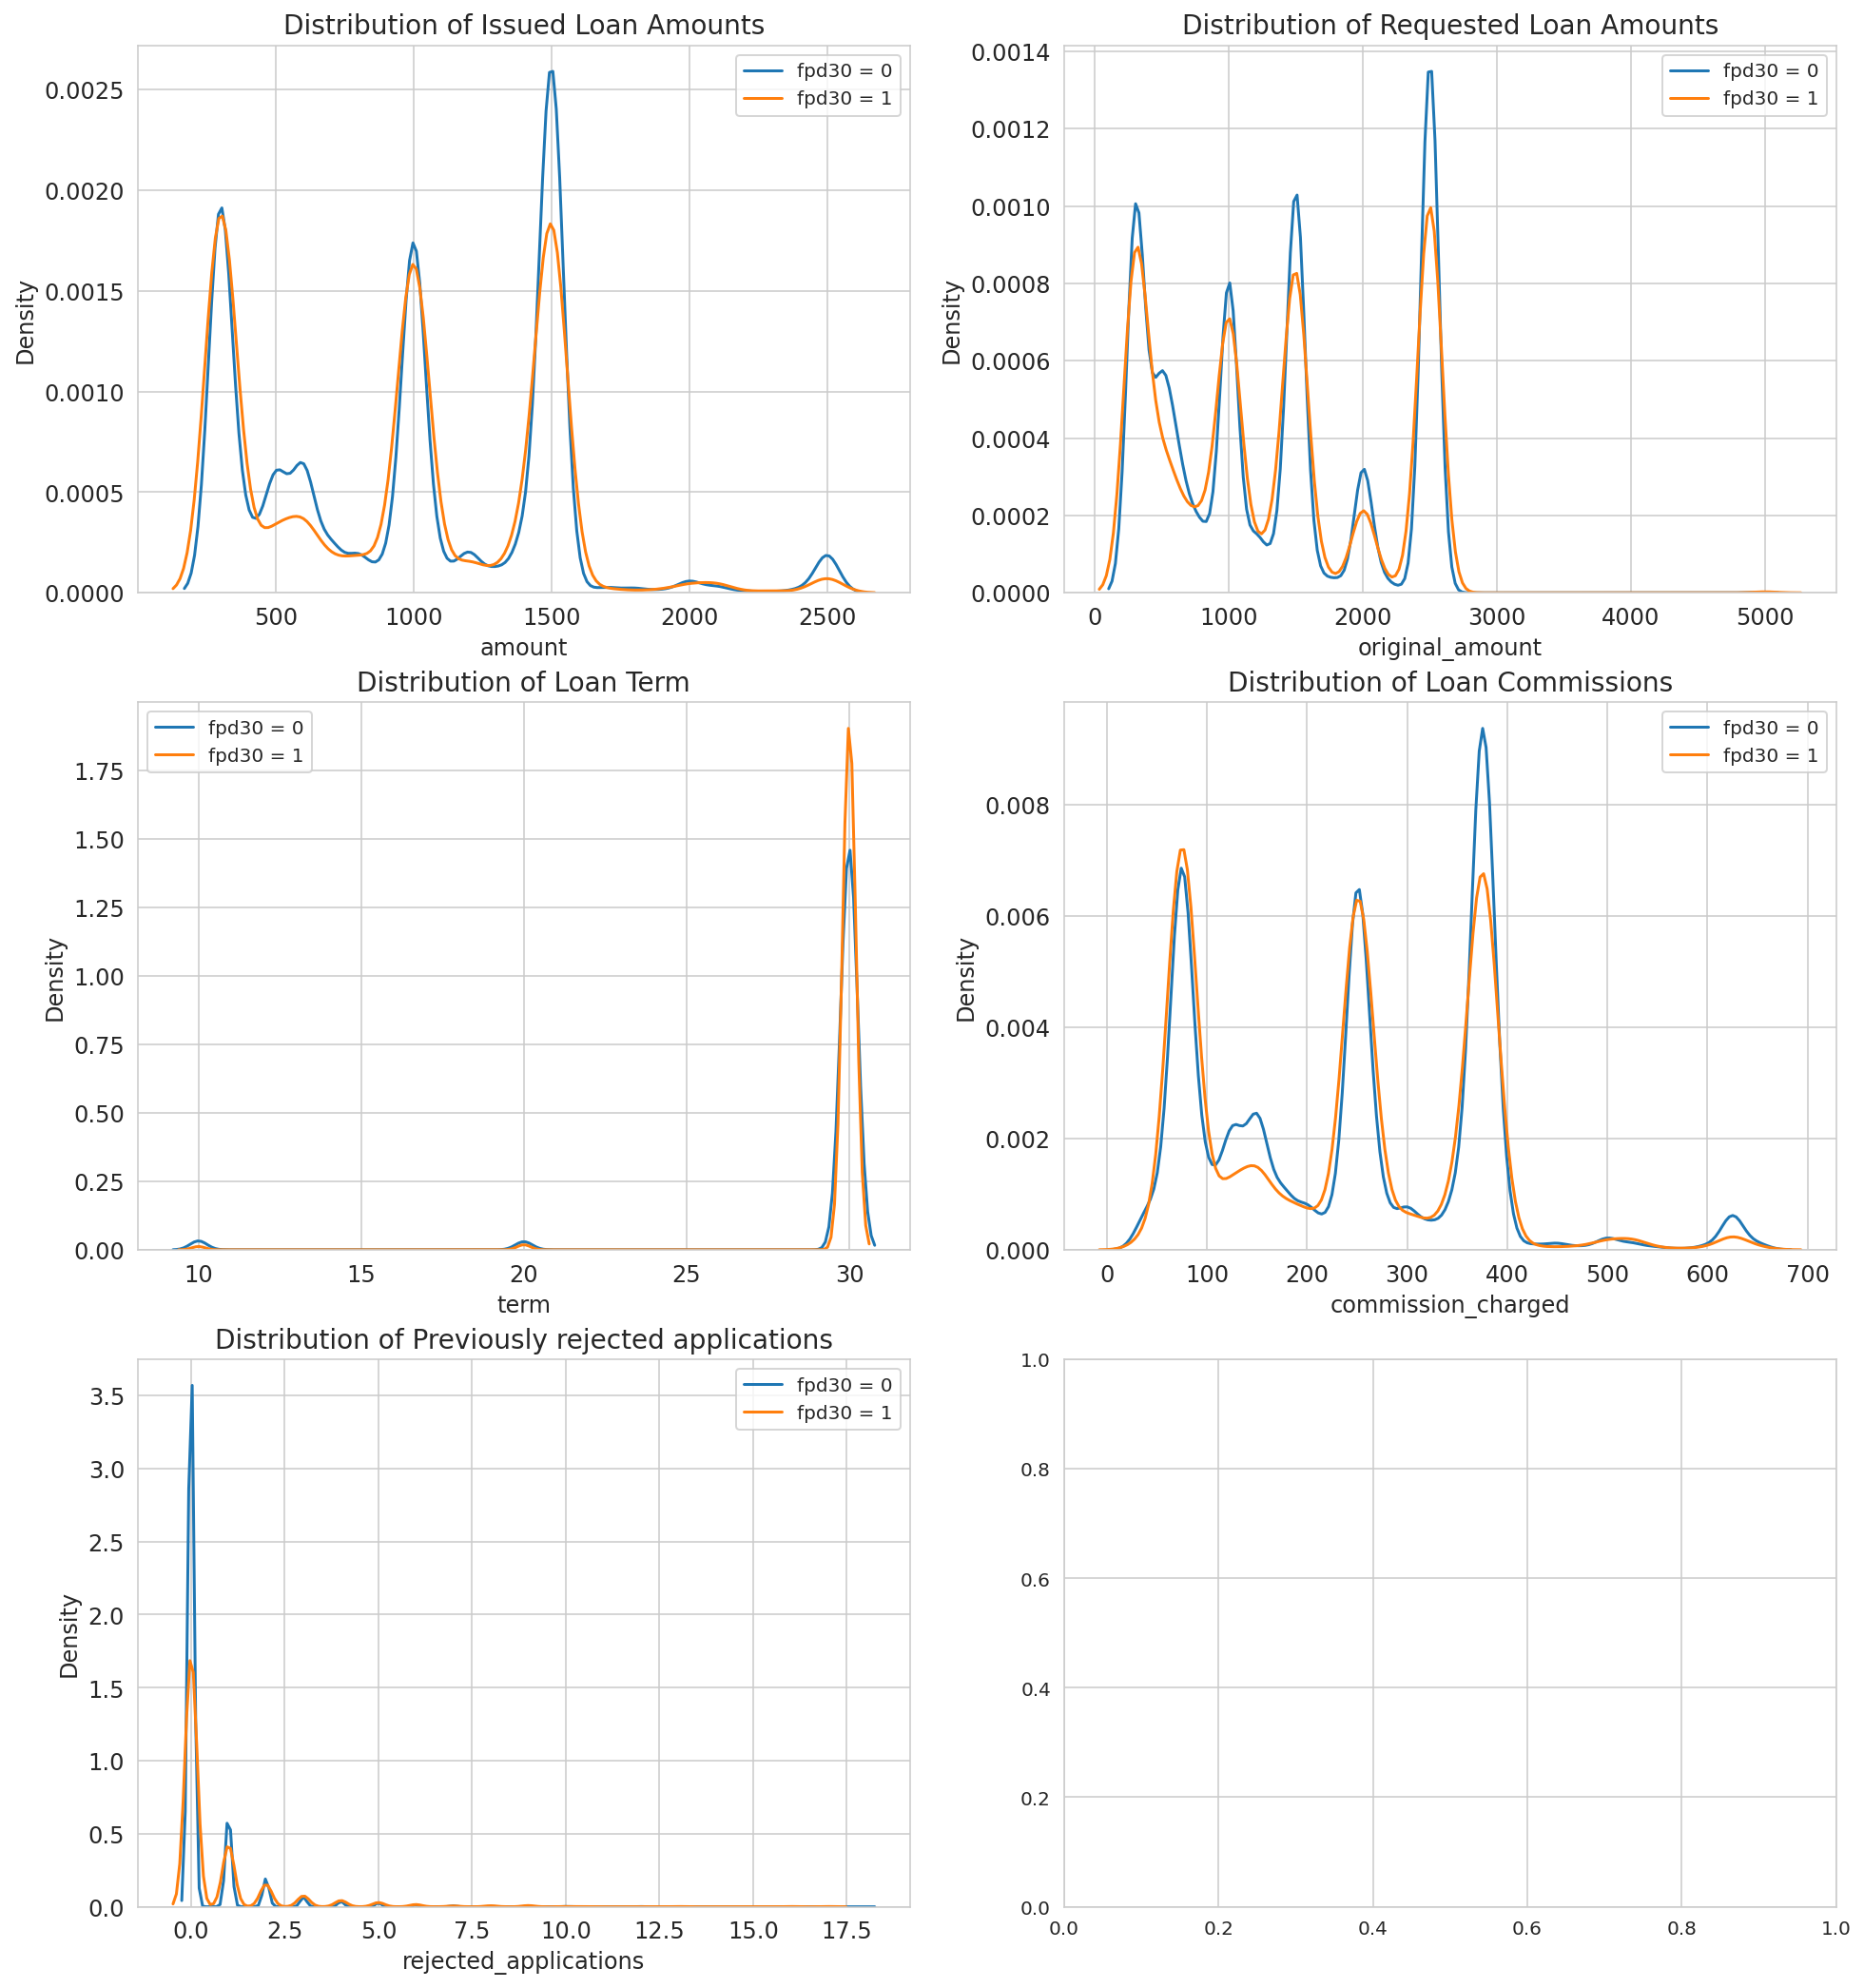

In [ ]:
var = ['amount', 'original_amount', 'term', 'commission_charged', 'rejected_applications']
titles = ['Issued Loan Amounts', 'Requested Loan Amounts', 'Loan Term', 'Loan Commissions', 'Previously rejected applications']

distribution_plot_several(var,titles,nrow=3)

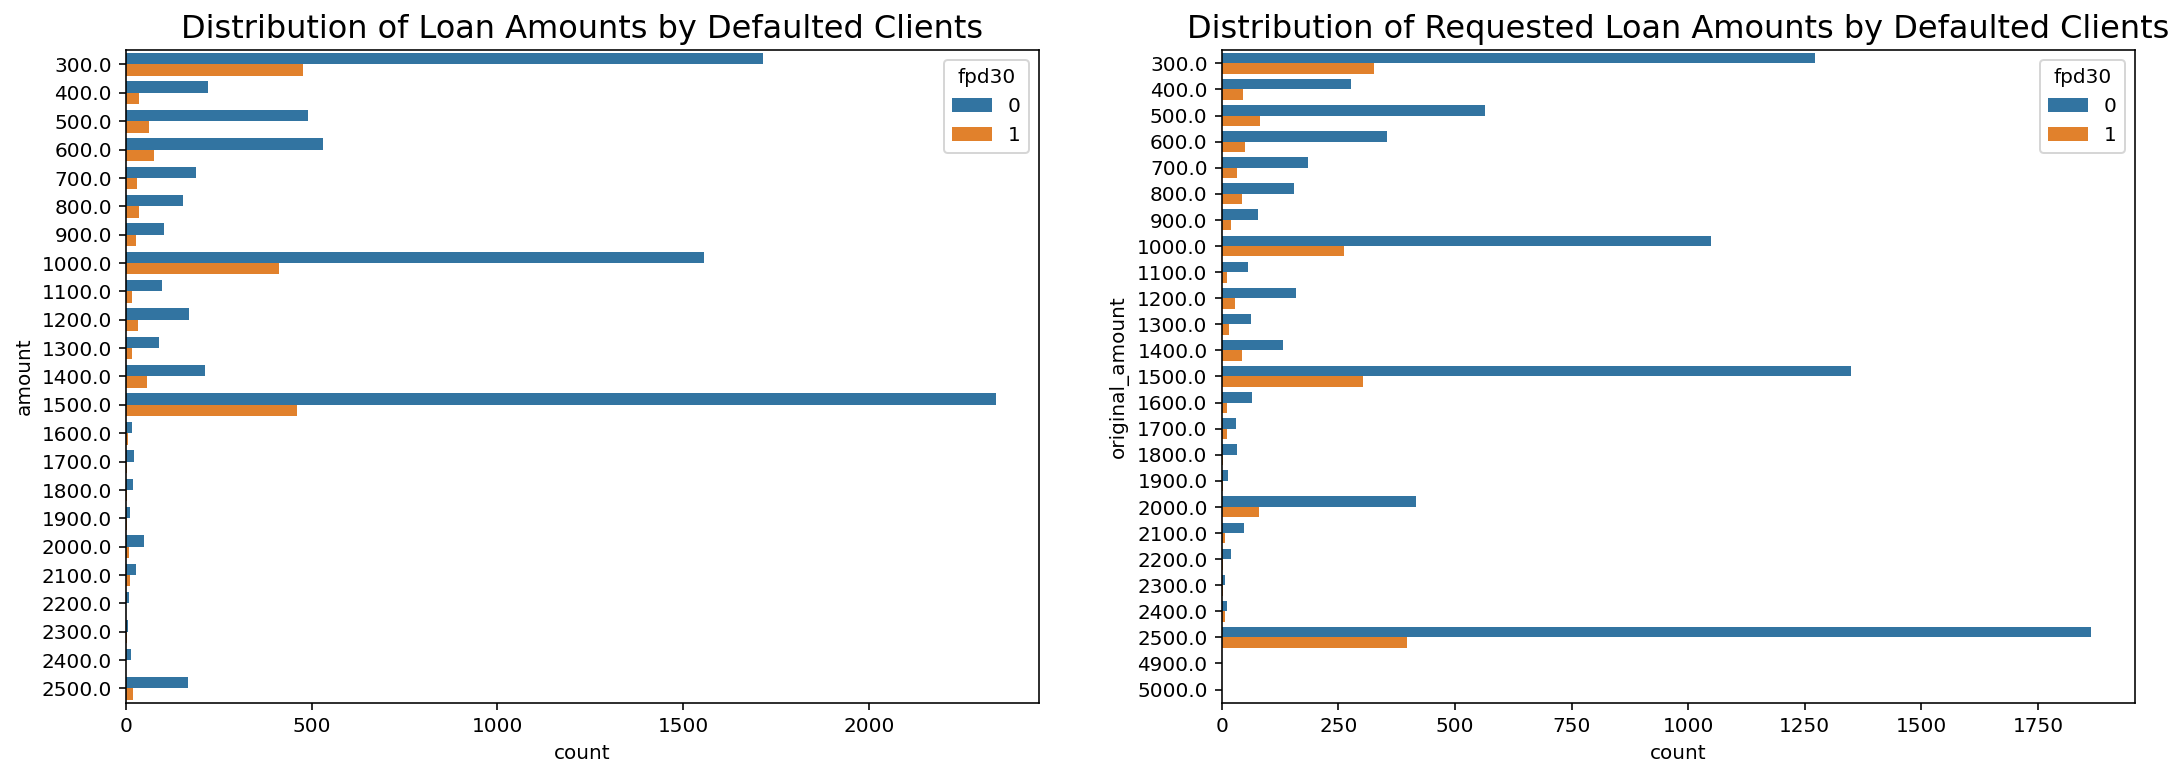

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(y="amount", hue="fpd30", data=df, ax=ax[0]);
ax[0].set_title('Distribution of Loan Amounts by Defaulted Clients', fontsize=16)

sns.countplot(y="original_amount", hue="fpd30", data=df, ax=ax[1]);
ax[1].set_title('Distribution of Requested Loan Amounts by Defaulted Clients', fontsize=16)

plt.show()

In [ ]:
pd.crosstab(df['fpd30'], df['term'], margins=True)

term,10,20,30,All
fpd30,,,,
0,174,159,7873,8206
1,11,17,1766,1794
All,185,176,9639,10000


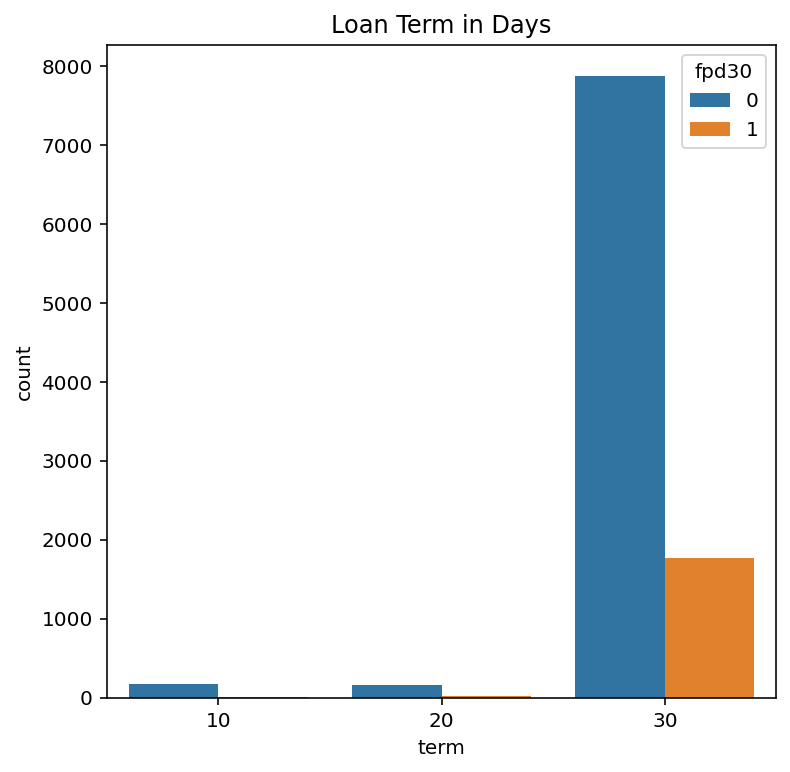

In [ ]:
plt.figure(figsize = (6,6))
plt.title('Loan Term in Days')
sns.set_color_codes("pastel")
sns.countplot(x='term', hue="fpd30", data=df)

plt.show()

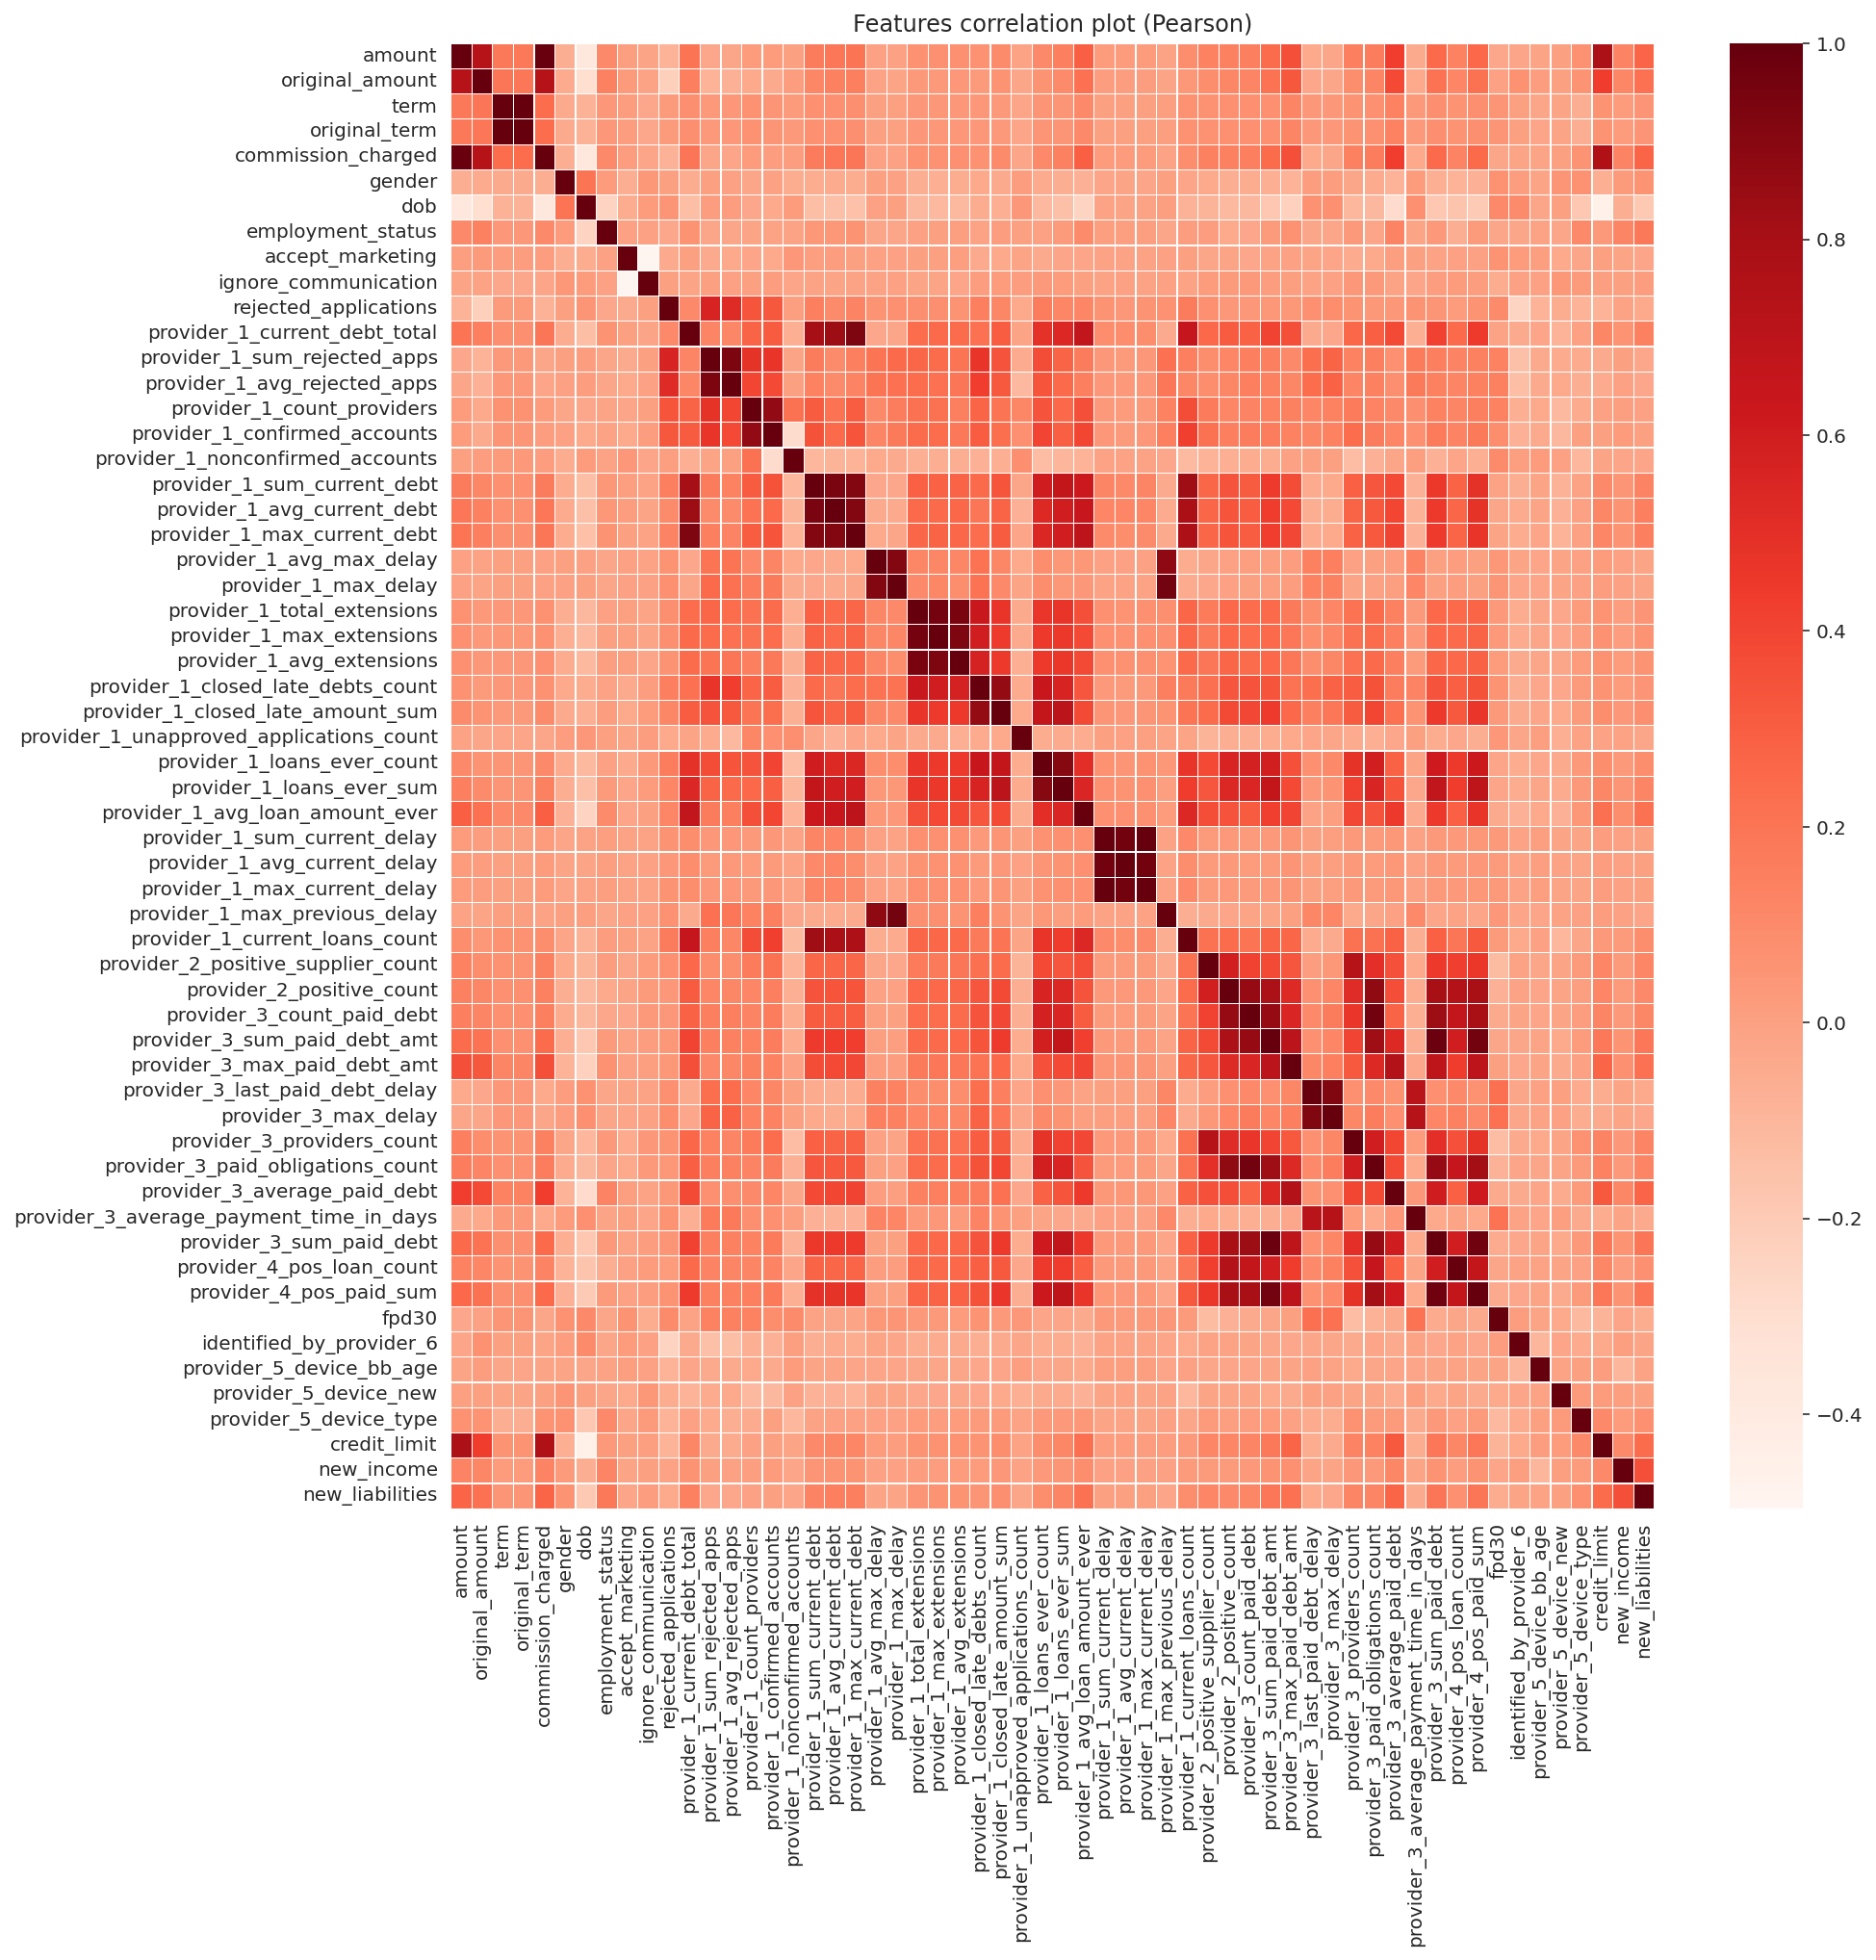

In [229]:
plt.figure(figsize = (14,14))
plt.title('Features correlation plot (Pearson)')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

In [ ]:
le_dev.inverse_transform([1, 1, 3])

In [227]:
df['provider_1_nonconfirmed_accounts'].unique()

array([1.        , 0.        , 3.        , 2.        , 4.        ,
       5.        , 0.54825483])